##PROBLEM 1: Supervised Classification Libraries: Regression, Decision Tree
6 Runs of Supervised Training / Testing : 3 datasets (MNIST, Spambase, 20NG) x 2 Classification Algorithms (L2-reg Logistic Regression, Decision Trees). <br>
You can use a library for the classification algorithms, and also can use any library/script to process data in appropriate formats.<br>
You are required to explain/analyze the model trained in terms of features : for each of the 6 runs list the top F=30 features. <br>
For the Regression these correspond to the highest-absolute-value F coefficients; for Decision Tree they are the first F splits. <br>
In particular for Decision Tree on 20NG, report performance for two tree sizes ( by depths of the tree, or number of leaves, or number of splits )

In [ ]:
!pip install idx2numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
import math
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.tree import DecisionTreeClassifier, plot_tree

#### Preprocessing MNIST

In [ ]:
# MNIST dataset
mnist_images = idx2numpy.convert_from_file("/content/drive/MyDrive/USML/HW 3A/MNIST/train-images.idx3-ubyte")
mnist_images_data = mnist_images.copy()
mnist_labels = idx2numpy.convert_from_file("/content/drive/MyDrive/USML/HW 3A/MNIST/train-labels.idx1-ubyte")
mnist_images_data = mnist_images_data.reshape(mnist_images.shape[0], -1)
mnist_images_data[mnist_images_data > 0] = 1
sparse_mnist_images_data = sp.csr_matrix(mnist_images_data)

mnist_images_test = idx2numpy.convert_from_file("/content/drive/MyDrive/USML/HW 3A/MNIST/t10k-images-idx3-ubyte")
mnist_images_test_data = mnist_images_test.copy()
mnist_labels_test = idx2numpy.convert_from_file("/content/drive/MyDrive/USML/HW 3A/MNIST/t10k-labels-idx1-ubyte")
mnist_images_test_data = mnist_images_test_data.reshape(mnist_images_test.shape[0], -1)
mnist_images_test_data[mnist_images_test_data > 0] = 1

In [ ]:
sparse_mnist_images_data.nnz / (sparse_mnist_images_data.shape[0] * sparse_mnist_images_data.shape[1])

0.19120229591836735

#### Preprocessing Spambase

In [ ]:
# Spambase dataset
spambase_dataset = np.loadtxt('/content/drive/MyDrive/USML/HW 3A/spambase/spambase.data', delimiter=',')
spambase_labels = spambase_dataset[:,57]
spambase_data = spambase_dataset[:,:57]

spambase_train_data, spambase_test_data, spambase_train_lbl, spambase_test_lbl = train_test_split(spambase_data, spambase_labels, test_size=0.2, random_state=42)

# Specify the path to your file
file_path = '/content/drive/MyDrive/USML/HW 3A/spambase/features'

# Open the file for reading
with open(file_path, 'r') as file:
    # Read each line in the file
    lines = file.readlines()

target_names = [string.strip() for string in lines]

#### Preprocessing 20NG

In [ ]:
# 20NG dataset
file_path = '/content/drive/MyDrive/USML/HW 3A/20NG/train_20NG_wo_header_footer_quotes.pkl'

with open(file_path, 'rb') as file:
    data = pickle.load(file)

def preprocess(text):
  def is_valid_word(word):
    return bool(wordnet.synsets(word))
  text = re.sub(r'[^a-zA-Z0-9 \n]', '', text) # removing any character that is not an alphanumeric character (letters and digits), a space, or a newline (\n)
  text = re.sub(r'\n+', ' ', text) # removing new line
  text = text.lower() # lower casing
  tokens = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words] # removing stop words
  filtered_tokens = [word for word in tokens if is_valid_word(word)] # removing non-english word

  return ' '.join(filtered_tokens)

preprocessed_data = []

for text in data['data']:
  preprocessed_data.append(preprocess(text))

vectorizer = TfidfVectorizer()
tng_data = vectorizer.fit_transform(preprocessed_data) # SHAPE:

tng_labels = data['target']

num_nonzero_elements = tng_data.nnz
total_elements = tng_data.shape[0] * tng_data.shape[1]
sparsity_ratio = 1 - (num_nonzero_elements / total_elements)
print(f"Sparsity ratio: {sparsity_ratio:.4f}")
print("Shape: ",tng_data.shape)

Sparsity ratio: 0.9983
Shape:  (11314, 32863)


In [ ]:
tng_train_data, tng_test_data, tng_train_lbl, tng_test_lbl = train_test_split(tng_data, tng_labels, test_size=0.2, random_state=42)

###Run 1: L2-reg Logistic Regression on MNIST

In [ ]:
log_reg_mnist = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000, multi_class='multinomial')
log_reg_mnist.fit(sparse_mnist_images_data, mnist_labels) # 3m

LogisticRegression(max_iter=5000, multi_class='multinomial')

#### Top 30 Features

In [ ]:
# Get the coefficients for each class
coefficients = log_reg_mnist.coef_

# Compute the absolute value of the coefficients
absolute_coefficients = np.abs(coefficients)

top_values_count = 30

# Get indices that would sort each row
sorted_indices = np.argsort(-absolute_coefficients, axis=1)

# Get the top indices from each sorted row
top_features = sorted_indices[:, :top_values_count]

In [ ]:
top_features

array([[716, 692, 193, 712, 717, 719, 379, 117, 434, 283,  71, 473, 323,
        663, 489, 362, 461, 378, 390, 224, 164, 475, 642, 312, 309, 278,
        713, 745, 746, 229],
       [557, 304, 640,  70, 509, 137, 740, 396, 172, 741, 276, 221, 466,
        144, 249, 277, 329,  95, 173, 331, 521, 609, 314, 374, 287, 150,
        411, 711, 710, 717],
       [390, 585, 473, 283, 474, 339, 529, 446, 723, 708, 709, 696, 416,
        501, 333,  90, 367, 642, 697, 389, 639,  65, 670, 558, 164, 675,
        720, 334, 340, 369],
       [284, 675, 395,  95, 107, 361, 612, 445, 720, 744, 638, 367, 707,
        740, 332, 665, 104, 423, 143, 709, 311, 501, 592, 144,  67, 710,
        479, 529, 446, 276],
       [ 96, 529, 390, 569, 479, 594, 117,  67, 118, 563, 222,  93, 770,
        277, 585,  44,  65,  66, 638, 220, 736, 507, 250, 132, 163, 199,
        748, 200,  43, 395],
       [304, 283, 312, 362, 256, 389, 390, 200, 359, 332, 305, 722, 388,
        278, 330, 276, 334, 667, 697, 558, 333, 221,

In [ ]:
def feature_coordinate(index):
  x = math.ceil(index/28)
  y = index%28
  if y==0:
    y=28
  return (x,y)

In [ ]:
top_features_coordinates = []
for class_features in top_features:
  class_feature_coordinate = []
  for feature in class_features:
    class_feature_coordinate.append(feature_coordinate(feature))
  top_features_coordinates.append(class_feature_coordinate)

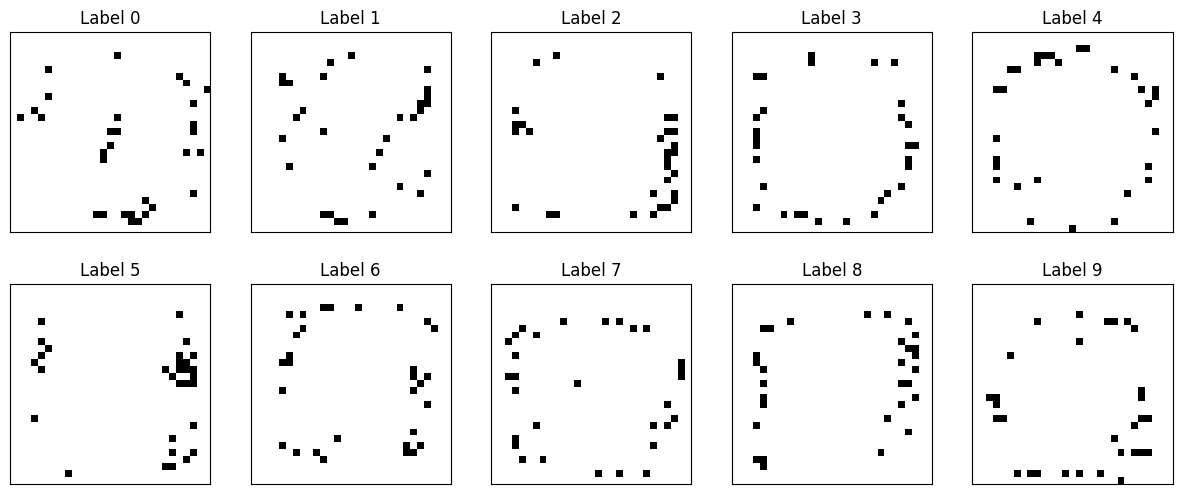

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for lbl in log_reg_mnist.classes_:
  viz_features = np.zeros((29,29))
  for feature in top_features_coordinates[lbl]:
    viz_features[feature] = 1
  ax = axes[lbl // 5, lbl % 5]
  ax.imshow(viz_features, cmap='binary')  # Use 'binary' colormap for clear contrast
  ax.set_title(f"Label {lbl}")
  ax.set_xticks([])
  ax.set_yticks([])

#### Classification performance

In [ ]:
mnist_pred = log_reg_mnist.predict(mnist_images_test_data)

In [ ]:
accuracy = accuracy_score(mnist_labels_test, mnist_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(mnist_labels_test, mnist_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.9179
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.91      0.89      0.90      1032
           3       0.89      0.92      0.90      1010
           4       0.91      0.92      0.92       982
           5       0.90      0.86      0.88       892
           6       0.94      0.95      0.94       958
           7       0.93      0.91      0.92      1028
           8       0.86      0.88      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



###Run 2: L2-reg Logistic Regression on Spambase

In [ ]:
log_reg_spambase = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)
log_reg_spambase.fit(spambase_train_data, spambase_train_lbl) # 5s

LogisticRegression(max_iter=5000)

#### Top 30 Features

In [ ]:
# Get the coefficients for each class
coefficients = log_reg_spambase.coef_

# Compute the absolute value of the coefficients
absolute_coefficients = np.abs(coefficients)

top_values_count = 30

# Get indices that would sort each row
sorted_indices = np.argsort(-absolute_coefficients, axis=1)

# Get the top indices from each sorted row
top_features = sorted_indices[:, :top_values_count]
for index in top_features[0]:
  print(target_names[index])

word_freq_george
char_freq_$
word_freq_000
word_freq_remove
word_freq_project
word_freq_hp
word_freq_conference
word_freq_meeting
word_freq_addresses
word_freq_edu
word_freq_cs
word_freq_lab
word_freq_data
char_freq_#
word_freq_free
char_freq_;
word_freq_technology
word_freq_business
word_freq_85
word_freq_credit
word_freq_pm
word_freq_original
word_freq_hpl
word_freq_3d
word_freq_re
word_freq_labs
word_freq_over
word_freq_our
word_freq_table
word_freq_order


#### Classification performance

In [ ]:
spambase_pred = log_reg_spambase.predict(spambase_test_data)

In [ ]:
accuracy = accuracy_score(spambase_test_lbl, spambase_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(spambase_test_lbl, spambase_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.9218
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93       531
         1.0       0.93      0.88      0.91       390

    accuracy                           0.92       921
   macro avg       0.92      0.92      0.92       921
weighted avg       0.92      0.92      0.92       921



###Run 3: L2-reg Logistic Regression on 20NG

In [ ]:
log_reg_ng = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, multi_class='multinomial')
log_reg_ng.fit(tng_train_data, tng_train_lbl) # 26s

LogisticRegression(max_iter=1000, multi_class='multinomial')

#### Top 30 Features

In [ ]:
# Refered from: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html
categories = data['target_names']
feature_names = np.asarray(vectorizer.get_feature_names_out())
for i, category in enumerate(categories):
  absolute_coefficients = np.abs(log_reg_ng.coef_[i])
  top30 = np.argsort(absolute_coefficients)[-30:]
  print("%s: %s" % (category, " ".join(feature_names[top30])))

alt.atheism: saying post kent tells say freewill evidence words liar argument exist define think moral satan atheist deletion quran objective religious morality bible islamic atheists motto bobby islam religion atheism god
comp.graphics: 42 thanks video hi software mode xv library algorithm ftp surface temp looking package code color viewer computer polygon points animation file tiff program format images files 3d image graphics
comp.os.ms-windows.misc: manager printer part directory version ink nt icon access font try called ftp using use mouse card dos program risc desktop fonts problem drivers 14 31 driver files file windows
comp.sys.ibm.pc.hardware: monitors help thanks western amd floppy 17 cards info speed cpu switch dos nec memory problem system computer drives disk port gateway board monitor pc controller scsi card bus drive
comp.sys.mac.hardware: hardware ram modem print upgrade accelerator cache meg external port machines macintosh internal ethernet problem speed problems clo

#### Classification performance

In [ ]:
tng_pred = log_reg_ng.predict(tng_test_data)
accuracy = accuracy_score(tng_test_lbl, tng_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(tng_test_lbl, tng_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.7163
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68        97
           1       0.65      0.69      0.67       104
           2       0.68      0.65      0.67       115
           3       0.65      0.65      0.65       123
           4       0.79      0.55      0.65       126
           5       0.72      0.82      0.77       106
           6       0.69      0.72      0.71       109
           7       0.75      0.73      0.74       139
           8       0.50      0.80      0.62       122
           9       0.71      0.78      0.74       102
          10       0.88      0.79      0.83       108
          11       0.92      0.83      0.87       125
          12       0.62      0.65      0.64       114
          13       0.76      0.78      0.77       119
          14       0.76      0.83      0.79       127
          15       0.72      0.77      0.75       122
          16       0.72      0.77      0.

###Run 4: Decision Tree on MNIST

In [ ]:
tree_clf_mnist = DecisionTreeClassifier()
tree_clf_mnist.fit(sparse_mnist_images_data, mnist_labels) #53s

DecisionTreeClassifier()

#### Top 30 Features

Values in a node refer to the distribution of samples across different classes at that particular node.
For a classification problem with multiple classes, Values would show how many samples belong to each class in that node.

Samples refers to the total number of samples (data points) that reach that node.

In the following tree Values are arrays and Samples is displayed in %

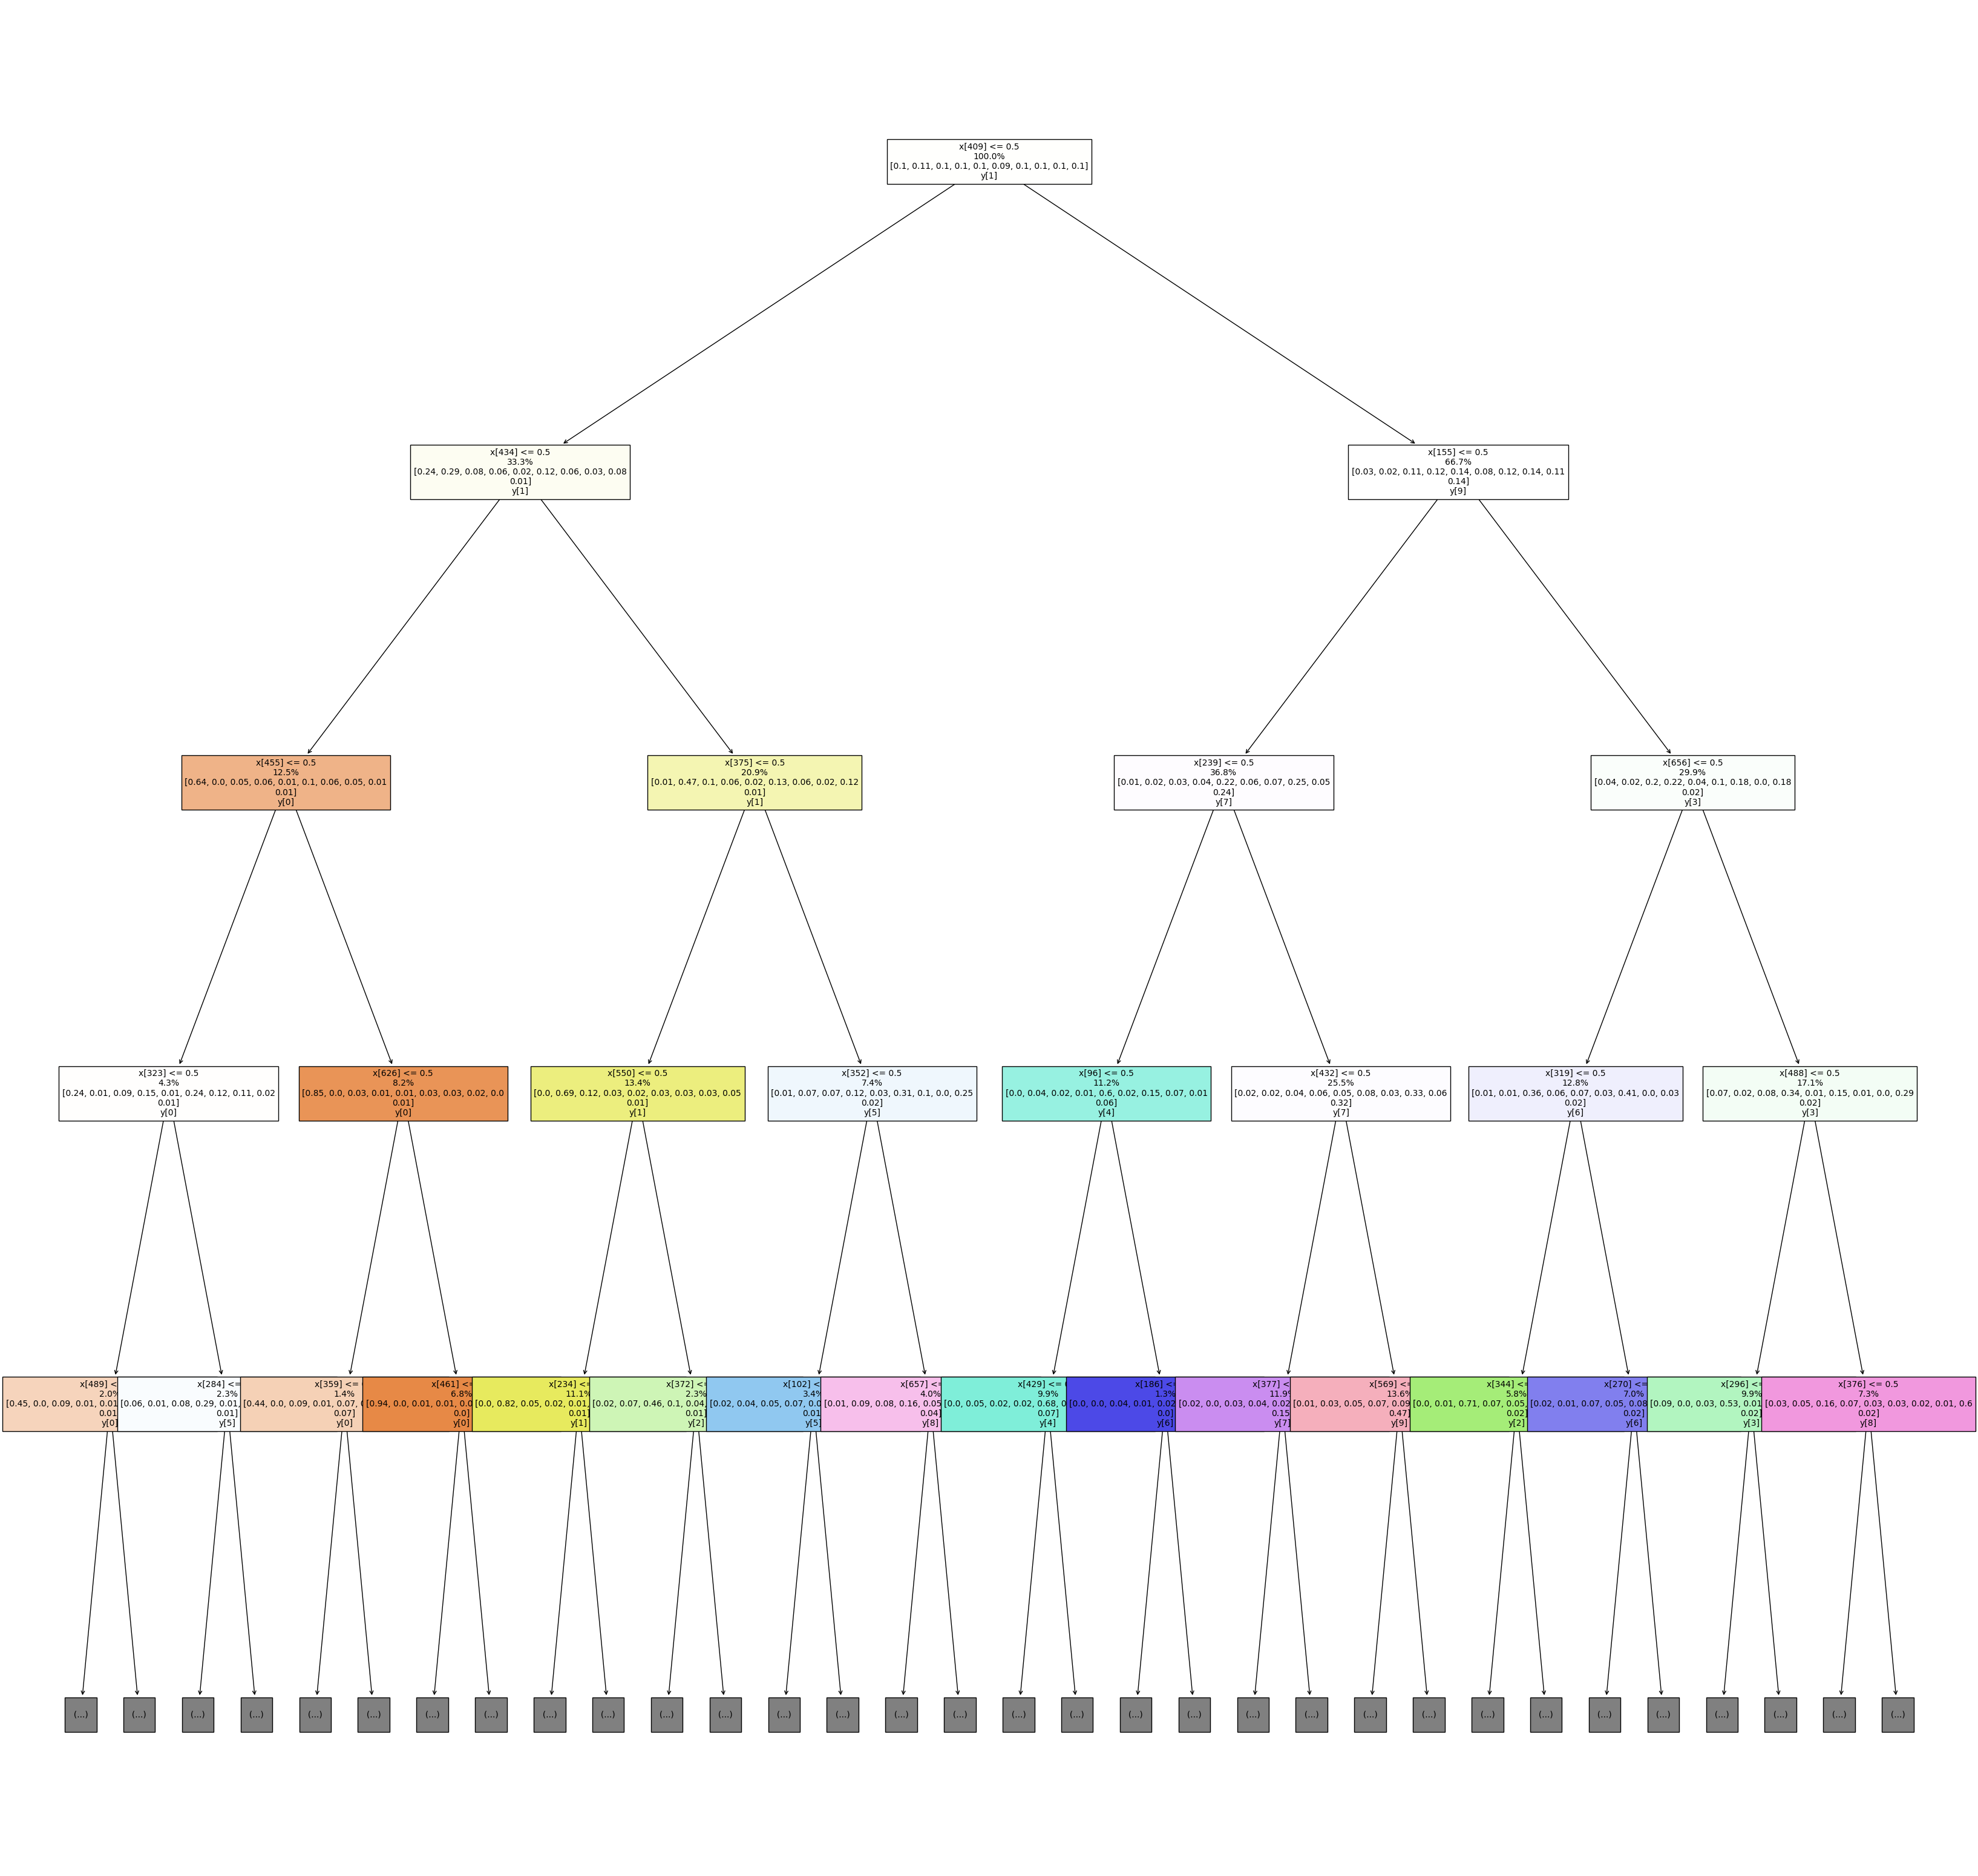

In [ ]:
plt.rcParams.update({'font.size': 12})  # Set default font size for nodes

plt.figure(figsize=(40, 40))
plot_tree(tree_clf_mnist, max_depth=4, fontsize=10,label=None,impurity=False,precision=2,proportion=True,filled=True,feature_names=None,class_names=True)
plt.savefig('decision_tree_mnist.png')

#### Classification performance

In [ ]:
mnist_pred_dt = tree_clf_mnist.predict(mnist_images_test_data)

In [ ]:
accuracy = accuracy_score(mnist_labels_test, mnist_pred_dt)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(mnist_labels_test, mnist_pred_dt)
print("Classification Report:")
print(class_report)

Accuracy: 0.8916
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       980
           1       0.94      0.96      0.95      1135
           2       0.88      0.88      0.88      1032
           3       0.84      0.86      0.85      1010
           4       0.89      0.90      0.90       982
           5       0.87      0.84      0.85       892
           6       0.91      0.91      0.91       958
           7       0.93      0.91      0.92      1028
           8       0.83      0.82      0.83       974
           9       0.88      0.88      0.88      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



###Run 5: Decision Tree on Spambase

In [ ]:
tree_clf_spambase = DecisionTreeClassifier()
tree_clf_spambase.fit(spambase_train_data, spambase_train_lbl) #1s

DecisionTreeClassifier()

#### Top 30 Features

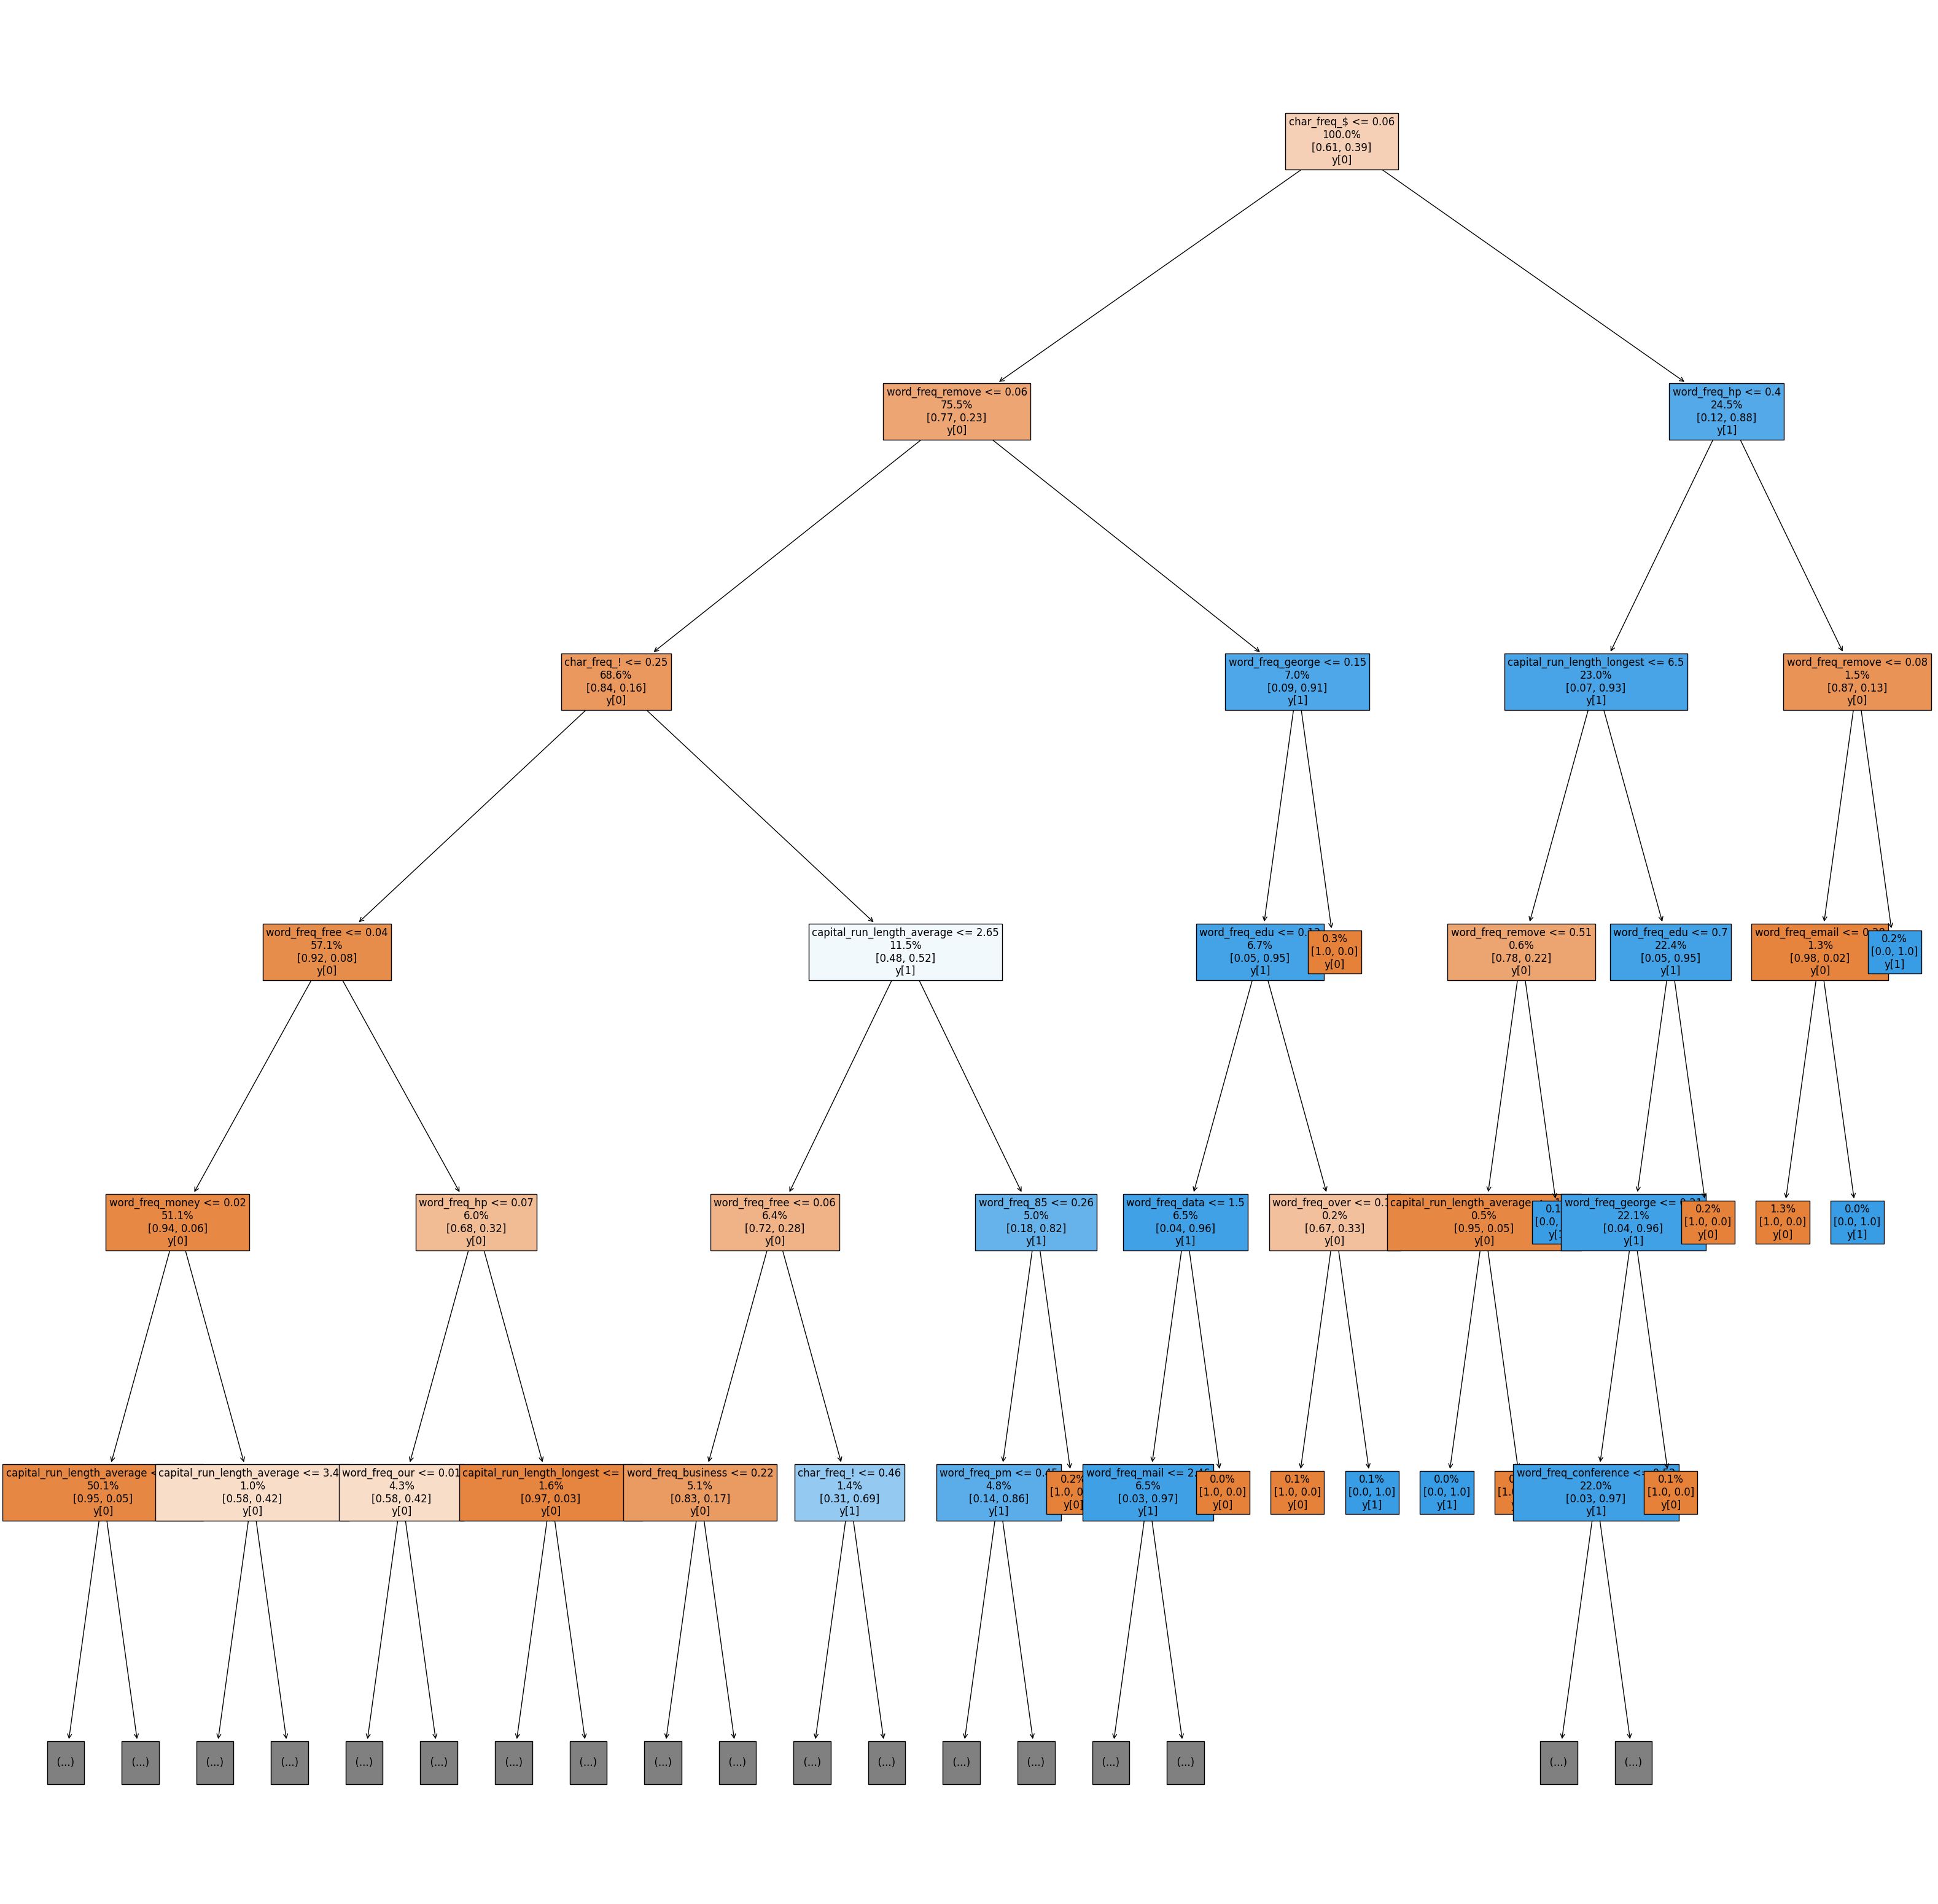

In [ ]:
plt.rcParams.update({'font.size': 12})  # Set default font size for nodes

plt.figure(figsize=(40, 40))
plot_tree(tree_clf_spambase, max_depth=5, fontsize=12,label=None,impurity=False,precision=2,proportion=True,filled=True,feature_names=target_names,class_names=True)
plt.savefig('decision_tree_spambase.png')

#### Classification performance

In [ ]:
spambase_pred_dt = tree_clf_spambase.predict(spambase_test_data)
accuracy = accuracy_score(spambase_test_lbl, spambase_pred_dt)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(spambase_test_lbl, spambase_pred_dt)
print("Classification Report:")
print(class_report)

Accuracy: 0.9197
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       531
         1.0       0.93      0.88      0.90       390

    accuracy                           0.92       921
   macro avg       0.92      0.91      0.92       921
weighted avg       0.92      0.92      0.92       921



###Run 6: Decision Tree on 20NG

In [ ]:
tree_clf_tng_low_depth = DecisionTreeClassifier(class_weight='balanced',max_depth=400)
tree_clf_tng_low_depth.fit(tng_train_data, tng_train_lbl)

tree_clf_tng_max_depth = DecisionTreeClassifier(class_weight='balanced')
tree_clf_tng_max_depth.fit(tng_train_data, tng_train_lbl)

DecisionTreeClassifier(class_weight='balanced')

In [ ]:
print(f"Depth of low-depth tree: {tree_clf_tng_low_depth.get_depth()} \nDepth of max-depth tree: {tree_clf_tng_max_depth.get_depth()}")

Depth of low-depth tree: 400 
Depth of max-depth tree: 637


#### Classification performance

In [ ]:
tng_pred_dt_low_depth = tree_clf_tng_low_depth.predict(tng_test_data)
accuracy = accuracy_score(tng_test_lbl, tng_pred_dt_low_depth)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(tng_test_lbl, tng_pred_dt_low_depth)
print("Classification Report:")
print(class_report)

Accuracy: 0.4565
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.31      0.33        97
           1       0.34      0.38      0.35       104
           2       0.49      0.50      0.50       115
           3       0.34      0.39      0.36       123
           4       0.46      0.32      0.38       126
           5       0.50      0.54      0.52       106
           6       0.52      0.50      0.51       109
           7       0.25      0.60      0.35       139
           8       0.58      0.50      0.54       122
           9       0.44      0.45      0.45       102
          10       0.62      0.52      0.57       108
          11       0.69      0.62      0.66       125
          12       0.40      0.32      0.36       114
          13       0.61      0.55      0.58       119
          14       0.62      0.46      0.53       127
          15       0.54      0.50      0.52       122
          16       0.48      0.40      0.

In [ ]:
tng_pred_dt_max_depth = tree_clf_tng_max_depth.predict(tng_test_data)
accuracy = accuracy_score(tng_test_lbl, tng_pred_dt_max_depth)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(tng_test_lbl, tng_pred_dt_max_depth)
print("Classification Report:")
print(class_report)

Accuracy: 0.4724
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.40      0.40        97
           1       0.39      0.38      0.39       104
           2       0.44      0.52      0.48       115
           3       0.39      0.41      0.40       123
           4       0.47      0.30      0.37       126
           5       0.48      0.54      0.51       106
           6       0.50      0.53      0.52       109
           7       0.31      0.60      0.41       139
           8       0.57      0.52      0.55       122
           9       0.49      0.50      0.49       102
          10       0.59      0.51      0.54       108
          11       0.67      0.65      0.66       125
          12       0.38      0.33      0.36       114
          13       0.51      0.57      0.54       119
          14       0.60      0.45      0.51       127
          15       0.56      0.51      0.53       122
          16       0.46      0.44      0.

#### Top 30 Features

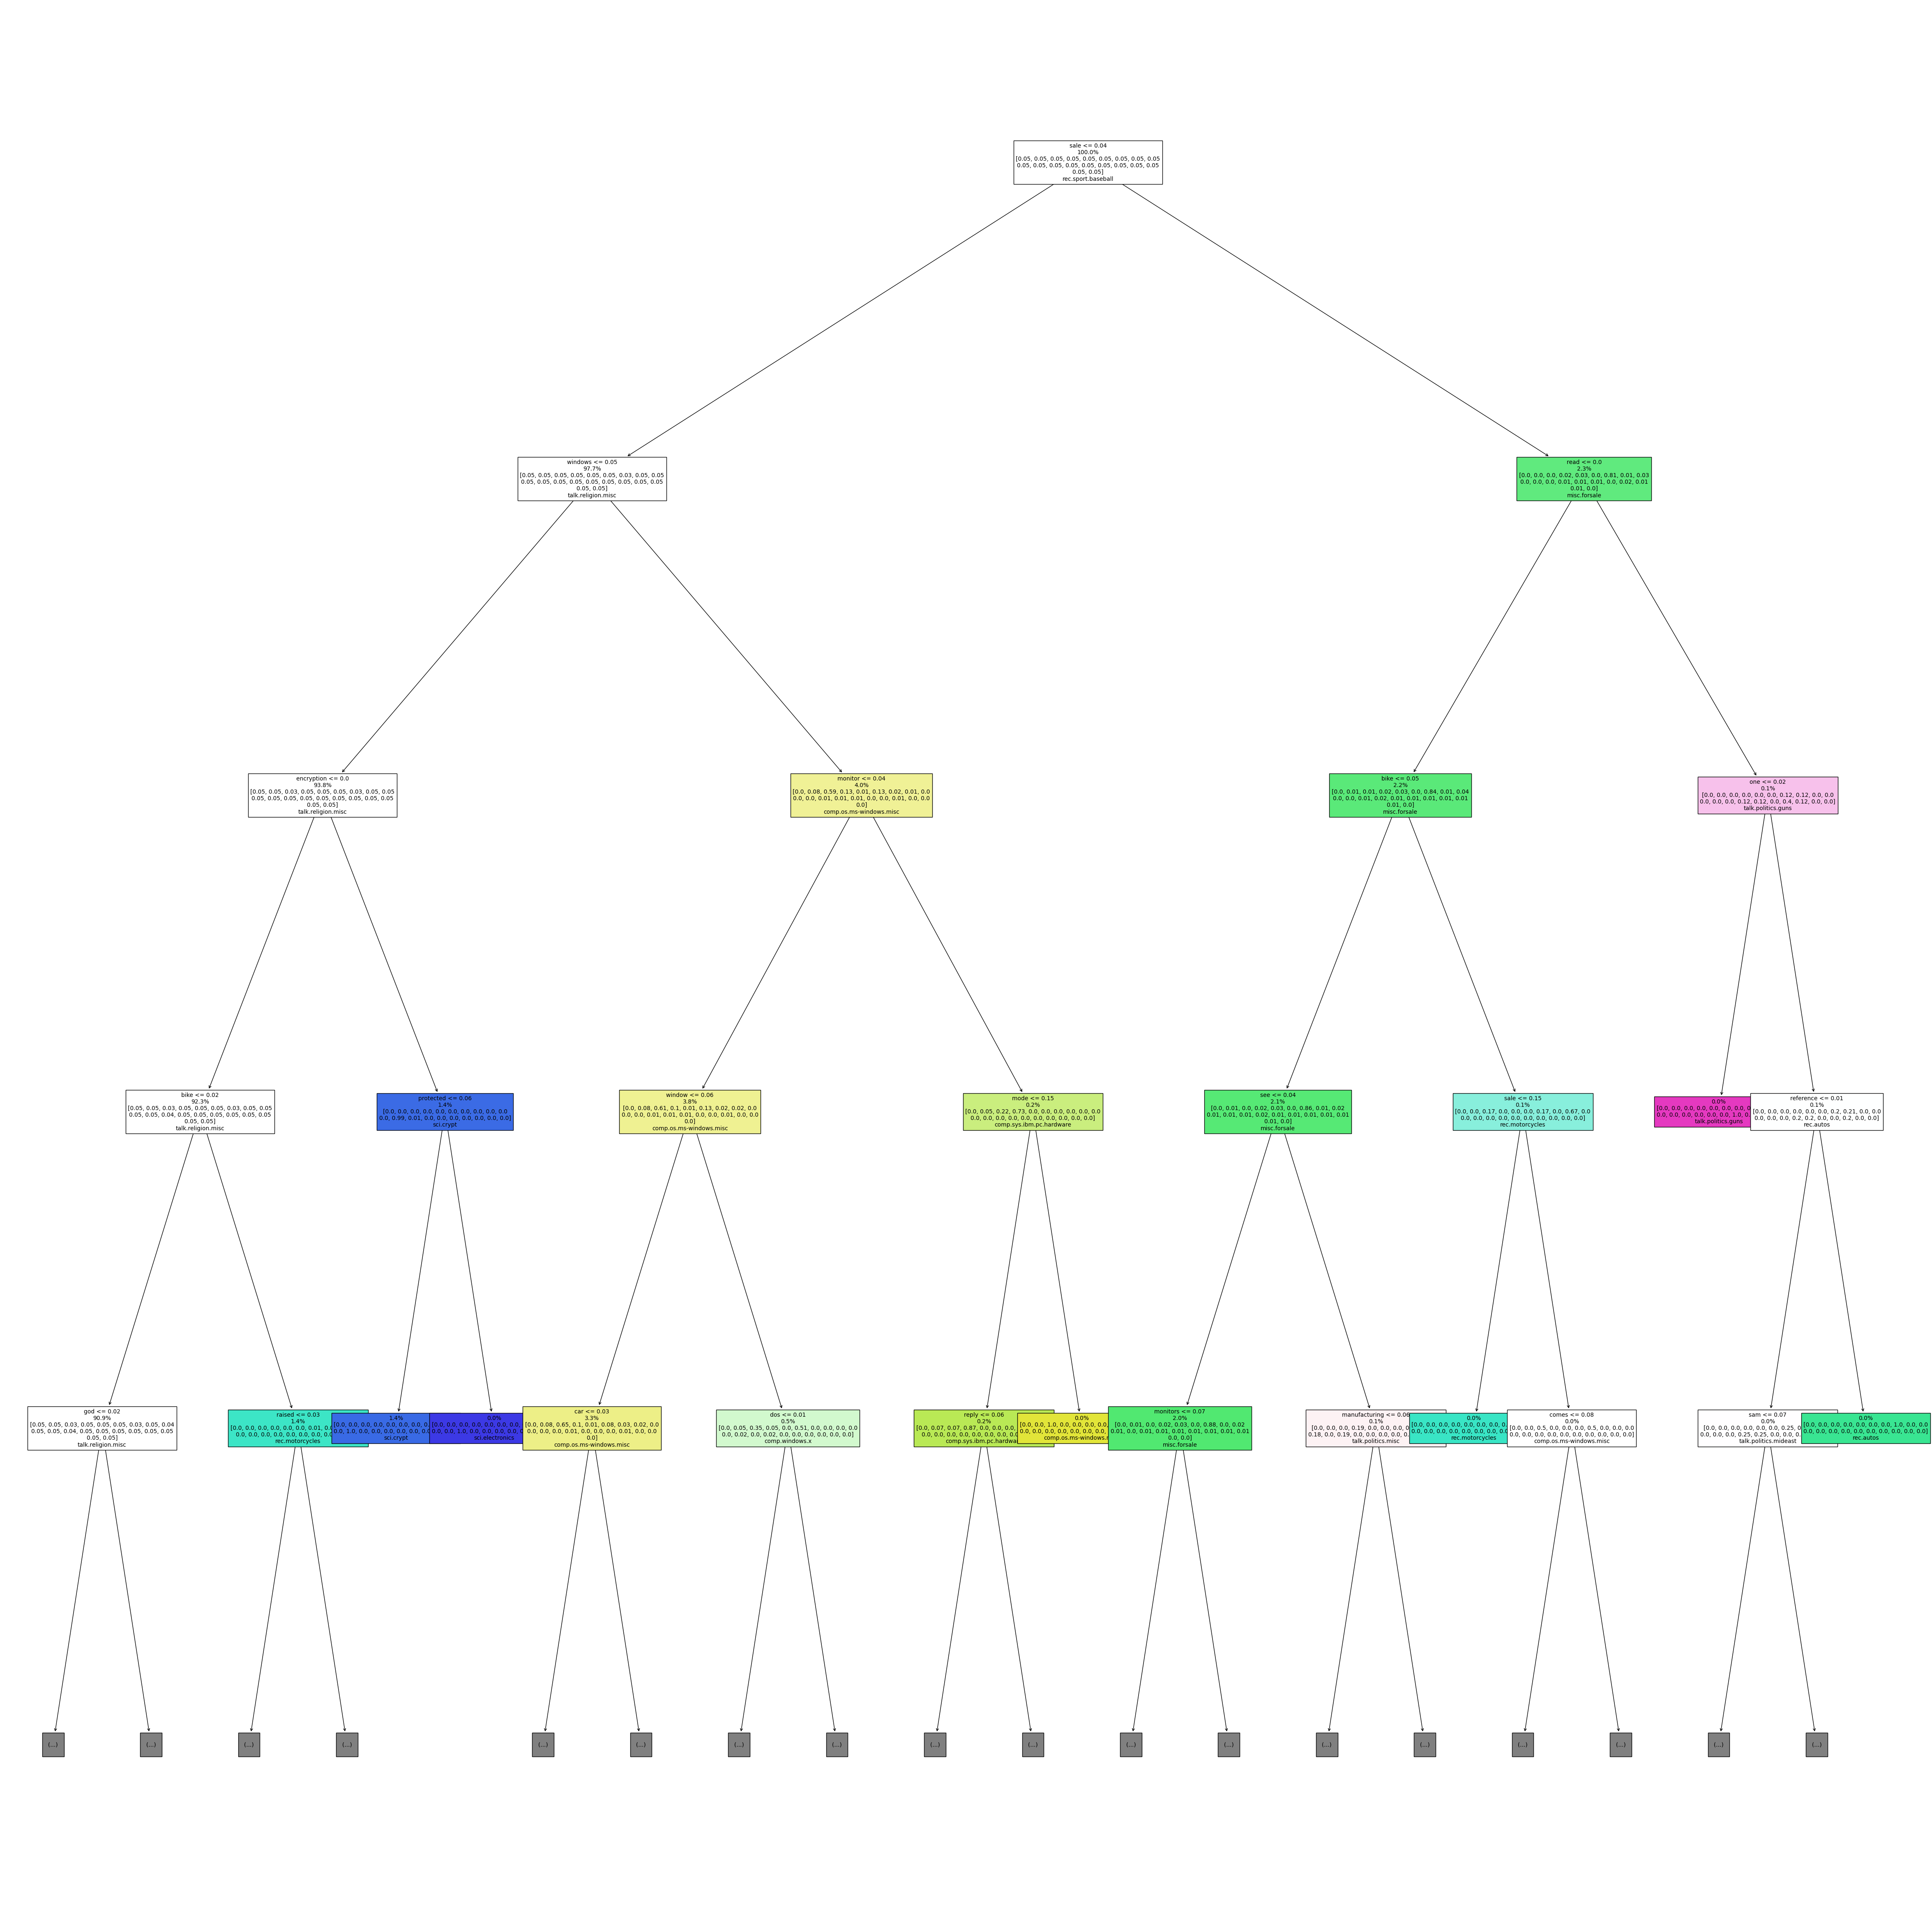

In [ ]:
feature_names = np.asarray(vectorizer.get_feature_names_out())

plt.rcParams.update({'font.size': 12})  # Set default font size for nodes
plt.figure(figsize=(60, 60))
plot_tree(tree_clf_tng_max_depth, max_depth=4, fontsize=10,label=None,impurity=False,precision=2,proportion=True,filled=True,feature_names=feature_names,class_names=data['target_names'])
plt.savefig('decision_tree_tng.png')